In [4]:
# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import numpy as np
import holodeck as holo
import holodeck.single_sources as ss
import holodeck.cyutils as cy
import matplotlib.pyplot as plt
import kalepy as kale


import matplotlib.cm as cm
from holodeck import plot, utils
from holodeck.constants import YR, MSOL, GYR

# Check flag replacement
## Fixed_Time

In [5]:
dur, cad = 17.5*YR, 0.2*YR
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
# sam = holo.sam.Semi_Analytic_Model()
sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
# hard = holo.hardening.Fixed_Time.from_sam(sam, 3*GYR)
# fobs_orb_edges = fobs_edges / 2.0 
# fobs_orb_cents = fobs/ 2.0
# edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) #, zero_stalled=True) # should the zero stalled option be part of the parameter space?
# edges[-1] = fobs_orb_edges


13:27:43 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
13:27:43 INFO : Stalled SAM bins based on GMT: 3.20e+03/8.00e+03 = 4.00e-01 [sam.py:static_binary_density]
13:27:43 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
13:27:43 INFO : 	dens bef: (1.28e-114, 1.11e-55, 2.00e-13, 1.79e-03, 1.69e-02, 3.04e-02, 4.47e-02) [sam.py:static_binary_density]
13:27:43 INFO : Scatter added after 0.141891 sec [sam.py:static_binary_density]
13:27:43 INFO : 	dens aft: (6.08e-15, 1.26e-08, 1.91e-06, 1.96e-03, 1.73e-02, 3.03e-02, 4.25e-02) [sam.py:static_binary_density]
13:27:43 INFO : 	mass: 8.91e-02 ==> 8.88e-02 || change = -3.5501e-03 [sam.py:static_binary_density]
13:27:43 INFO : zeroing out 3.20e+03/8.00e+03 = 4.00e-01 systems stalled from GMT [sam.py:static_binary_density]
13:27:43 INFO : fraction of coalesced binaries: 1.56e+04/3.44e+05 = 4.52e-02 [sam.py:dynamic_binary_number]
13:27:43 INFO : stalled binaries are not being accounted for in

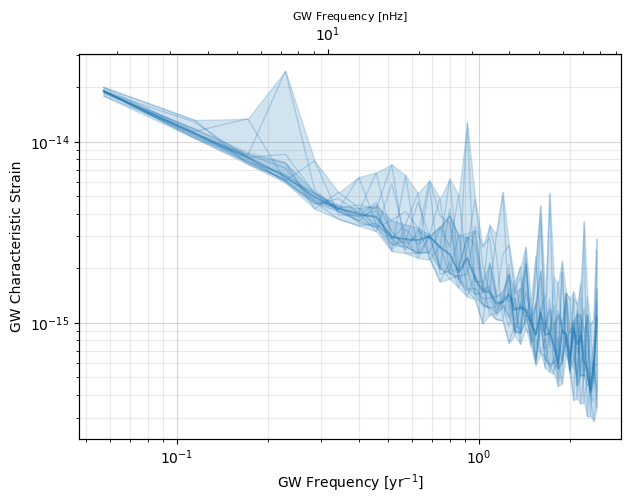

In [6]:
# just using gwb() function
gwb = sam.gwb(fobs_edges, realize=10)
fig = plot.plot_gwb(fobs, gwb)

13:27:44 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
13:27:44 INFO : fraction of coalesced binaries: 1.56e+04/3.44e+05 = 4.52e-02 [sam.py:dynamic_binary_number]
13:27:44 INFO : stalled binaries are not being accounted for in `dynamic_binary_number`! [sam.py:dynamic_binary_number]
13:27:44 WARNING : Using `redz_prime` for redshift (includes galaxy merger time, but not evolution time) [sam.py:gwb]


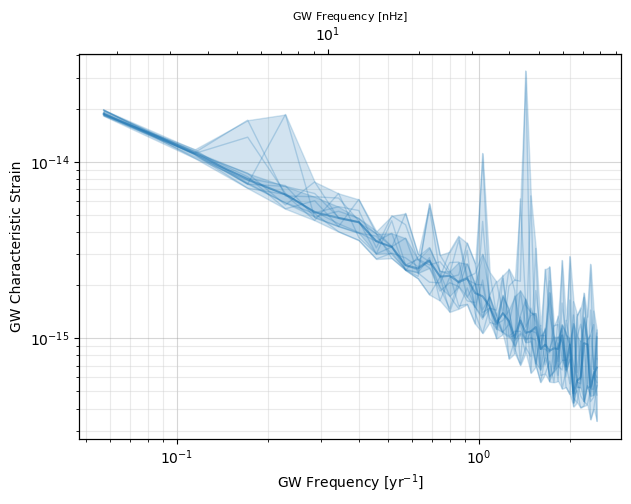

In [7]:
# just using gwb() function

gwb = sam.gwb(fobs_edges, hard=holo.hardening.Hard_GW, realize=10)
fig = plot.plot_gwb(fobs, gwb)

Fixed_Time dadt issue: Need to create a Fixed_Time instance, like by hard = holo.hardening.Fixed_Time.from_sam(sam, 3*GYR)

# ss_gws_redz using sam.ss_gwb()
## with Hard_GW

In [8]:
hc_ss, hc_bg, sspar, bgpar = sam.ss_gwb(fobs_edges, hard=holo.hardening.Hard_GW, realize = 10, loudest = 5, params = True)

SS 1: 
Current memory usage: max=0.42 GB, RSS=0.42 GB, VMS=391.13 GB
13:27:44 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
13:27:44 INFO : fraction of coalesced binaries: 1.56e+04/3.44e+05 = 4.52e-02 [sam.py:dynamic_binary_number]
13:27:44 INFO : stalled binaries are not being accounted for in `dynamic_binary_number`! [sam.py:dynamic_binary_number]
SS 2: 
Current memory usage: max=0.42 GB, RSS=0.42 GB, VMS=391.13 GB
SS 3: 
Current memory usage: max=0.43 GB, RSS=0.43 GB, VMS=391.13 GB
13:27:45 WARNING : Using `redz_prime` for redshift (includes galaxy merger time, but not evolution time) [sam.py:ss_gwb]
SS 4: 
Current memory usage: max=0.44 GB, RSS=0.44 GB, VMS=391.13 GB


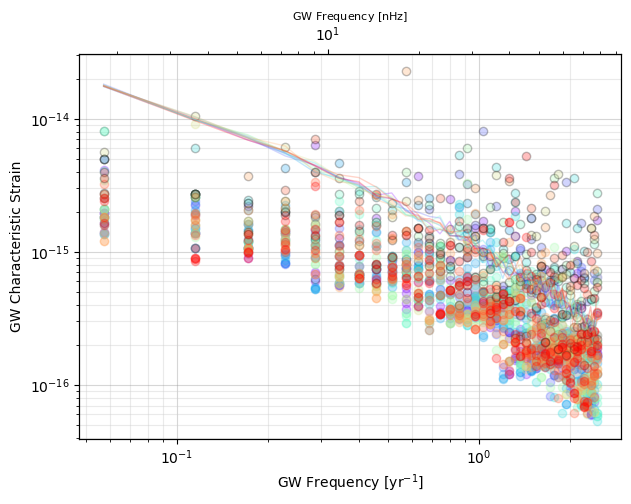

In [9]:
fig = plot.plot_bg_ss(fobs, hc_bg, hc_ss)

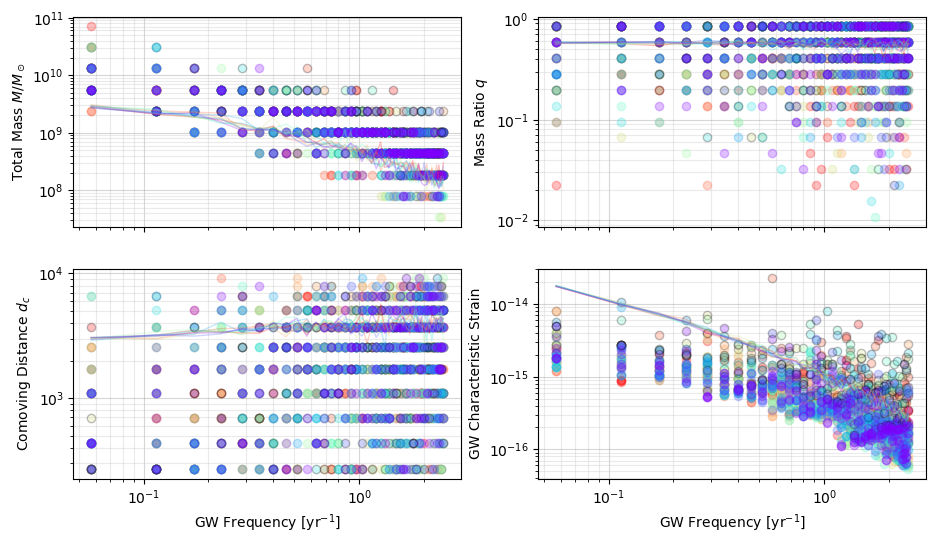

In [10]:
fig = plot.plot_pars(fobs, hc_ss, hc_bg, sspar, bgpar)

SS 1: 
Current memory usage: max=0.45 GB, RSS=0.45 GB, VMS=391.14 GB
13:27:47 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
13:27:47 INFO : fraction of coalesced binaries: 1.56e+04/3.44e+05 = 4.52e-02 [sam.py:dynamic_binary_number]
13:27:47 INFO : stalled binaries are not being accounted for in `dynamic_binary_number`! [sam.py:dynamic_binary_number]
SS 2: 
Current memory usage: max=0.45 GB, RSS=0.45 GB, VMS=391.14 GB
SS 3: 
Current memory usage: max=0.45 GB, RSS=0.45 GB, VMS=391.14 GB
13:27:47 WARNING : Using `redz_prime` for redshift (includes galaxy merger time, but not evolution time) [sam.py:ss_gwb]
SS 4: 
Current memory usage: max=0.46 GB, RSS=0.46 GB, VMS=391.14 GB


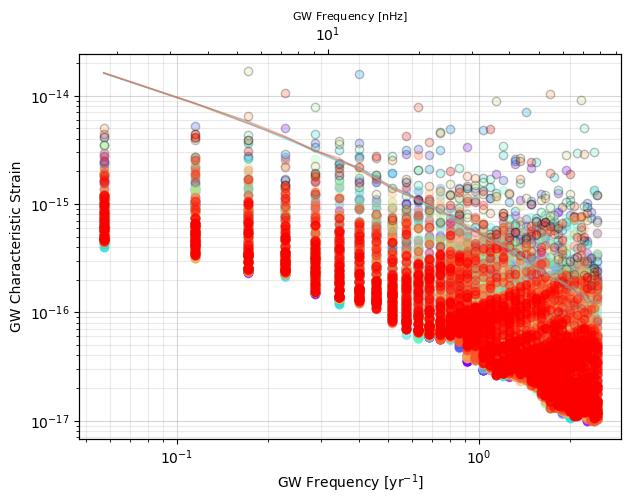

In [11]:
hc_ss, hc_bg = sam.ss_gwb(fobs_edges, realize=30, loudest=100, params=False)
fig = plot.plot_bg_ss(fobs, hc_bg, hc_ss)

## With Fixed_Time

13:27:52 WARNING : class `Fixed_Time` has been deprecated!  Please use `Fixed_Time_2PL` with new parametrization! [hardening.py:__init__]
13:27:52 INFO : calculating normalization exactly [hardening.py:__init__]
SS 1: 
Current memory usage: max=0.48 GB, RSS=0.48 GB, VMS=391.16 GB
13:27:54 INFO : zero_coalesced=False, zero_stalled=True [sam.py:dynamic_binary_number]
13:27:54 WARNING : WARNING: _coalesced_ binaries are not being accounted for in `dynamic_binary_number`! [sam.py:dynamic_binary_number]
13:27:54 INFO : fraction of stalled bins-xvals: 2.06e+05/3.44e+05 = 5.98e-01 [sam.py:dynamic_binary_number]
13:27:54 INFO : fraction of bins stalled at all xvals: 5.07e+03/8.00e+03 = 6.33e-01 [sam.py:dynamic_binary_number]
SS 2: 
Current memory usage: max=0.56 GB, RSS=0.56 GB, VMS=391.17 GB
SS 3: 
Current memory usage: max=0.56 GB, RSS=0.56 GB, VMS=391.17 GB
SS 4: 
Current memory usage: max=0.56 GB, RSS=0.56 GB, VMS=391.17 GB


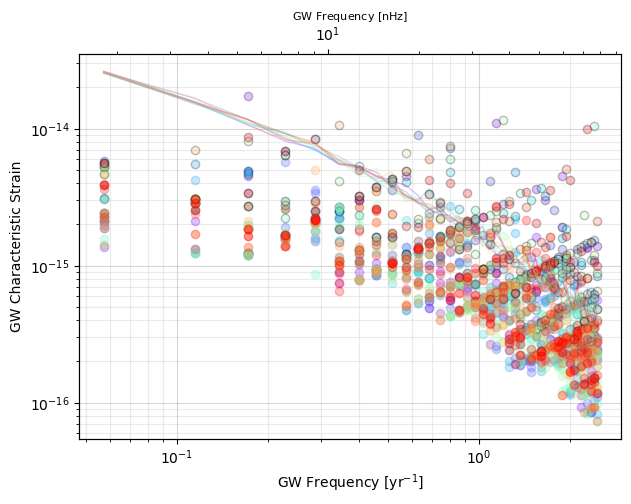

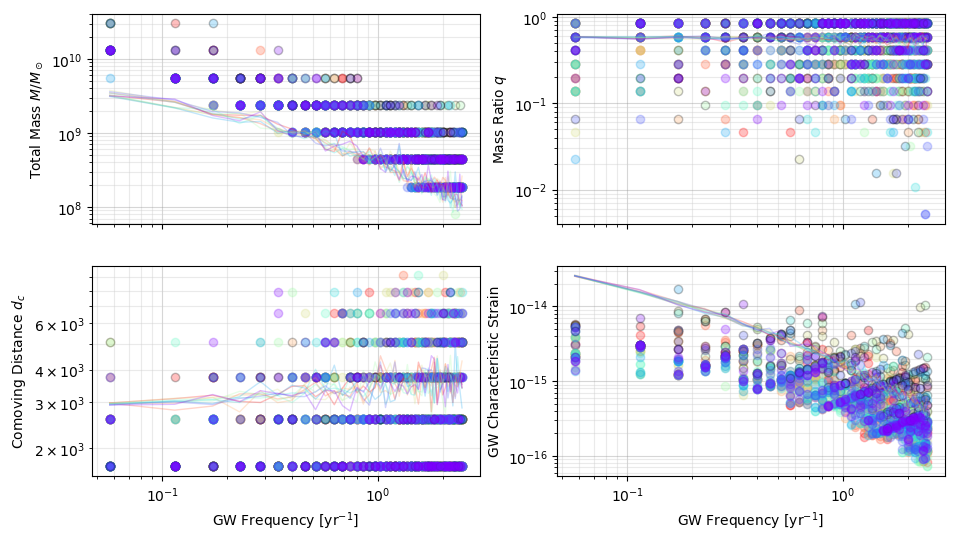

In [12]:
hard = holo.hardening.Fixed_Time.from_sam(sam, 3*GYR)
hc_ss, hc_bg, sspar, bgpar = sam.ss_gwb(fobs_edges, hard=hard, realize = 10, loudest = 5, params = True)
fig = plot.plot_bg_ss(fobs, hc_bg, hc_ss)
fig = plot.plot_pars(fobs, hc_ss, hc_bg, sspar, bgpar )

SS 1: 
Current memory usage: max=0.57 GB, RSS=0.57 GB, VMS=391.18 GB
13:27:56 INFO : zero_coalesced=False, zero_stalled=True [sam.py:dynamic_binary_number]
13:27:56 WARNING : WARNING: _coalesced_ binaries are not being accounted for in `dynamic_binary_number`! [sam.py:dynamic_binary_number]
13:27:56 INFO : fraction of stalled bins-xvals: 2.06e+05/3.44e+05 = 5.98e-01 [sam.py:dynamic_binary_number]
13:27:56 INFO : fraction of bins stalled at all xvals: 5.07e+03/8.00e+03 = 6.33e-01 [sam.py:dynamic_binary_number]
SS 2: 
Current memory usage: max=0.63 GB, RSS=0.63 GB, VMS=391.18 GB
SS 3: 
Current memory usage: max=0.63 GB, RSS=0.63 GB, VMS=391.18 GB
SS 4: 
Current memory usage: max=0.63 GB, RSS=0.63 GB, VMS=391.18 GB


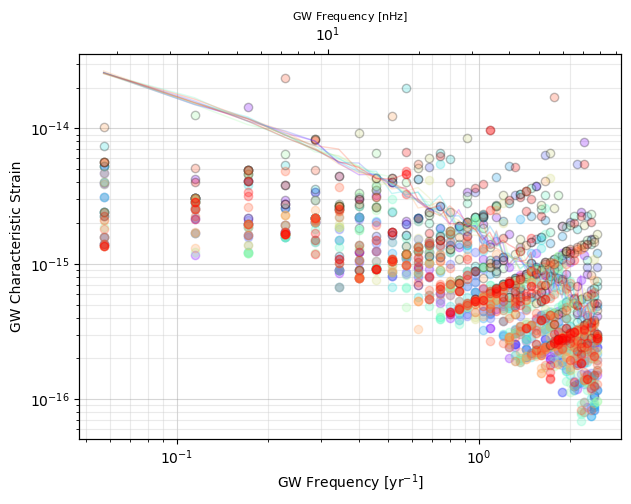

In [13]:
hc_ss, hc_bg = sam.ss_gwb(fobs_edges, hard=hard, realize = 10, loudest = 5, params = False)
fig = plot.plot_bg_ss(fobs, hc_bg, hc_ss)